In [1]:
import numpy as np

In [2]:
size = 10
n_steps = 2 * size * size

In [3]:
import dill
dill.load_session('600gen.db')

# Setting up the stage

TODO: consider punishment renormalization, make selection of parents based on probability

In [47]:
class Predator:
    
#gene is p that there is a can here

    def __init__(self, size, chromosome):
        assert chromosome.size == size * size
        self.size = size
        self.field = np.reshape(np.asarray([np.int(np.random.uniform(0, 1) <= gene) for gene in chromosome]), (size, -1))
        self.chromosome = chromosome

#0 - empty, 1 - can, 2 - wall, stay = 0, URDL_Pickup = 12345, Random = 6
        
class Prey:
    
    def __init__(self, chromosome):
        assert chromosome.size == 243
        self.chromosome = chromosome
    
    #observation is a 5-trit number in a ternary system, rightmost trit is Under, leftmost is left, rightmost index is 0
    def decide(self, observation):
        index = np.sum(np.asarray([observation[i] * (3 ** i) for i in range(observation.size)]))
        return self.chromosome[np.int(index)]
    
class Game:
    
    def __init__(self, Prey, Predator, max_steps = 2 * size * size, pickup_reward = 10, dummy_fine = 1, hit_fine = 5):
        self.pos = [0, 0]
        self.prey = Prey
        self.predator = Predator
        
        self.max_reward = pickup_reward * np.sum(self.predator.field)
        self.current_reward = max_steps * hit_fine
        self.steps_left = max_steps
        
        self.pickup_reward = pickup_reward
        self.dummy_fine = dummy_fine 
        self.hit_fine = hit_fine
    
    #observing and making a decision
    def observe_decide(self):
        observation = np.zeros(5)
        
        #under
        observation[0] = self.predator.field[self.pos[0], self.pos[1]]
        
        #up
        if(self.pos[0] == 0):
            observation[1] = 2
        else:
            observation[1] = self.predator.field[self.pos[0] - 1, self.pos[1]]
        
        #right
        if(self.pos[1] == (self.predator.size - 1)):
            observation[2] = 2
        else:
            observation[2] = self.predator.field[self.pos[0], self.pos[1] + 1]
            
        #down
        if(self.pos[0] == (self.predator.size - 1)):
            observation[3] = 2
        else:
            observation[3] = self.predator.field[self.pos[0] + 1, self.pos[1]]
            
        if(self.pos[1] == 0):
            observation[4] = 2
        else:
            observation[4] = self.predator.field[self.pos[0], self.pos[1] - 1]
        
        return self.prey.decide(observation)
    
    
    
    def step(self, decision):
        self.steps_left -= 1
        
        if (decision == 6):
            dec = np.int(np.trunc(np.random.uniform(1, 5)))
            
        else:
            dec = decision
        
        if (dec == 0):
            self.pos = self.pos
            
        elif (dec == 1):
            if (self.pos[0] == 0):
                self.current_reward -= self.hit_fine
            else:
                self.pos[0] -= 1
                
        elif (dec == 2):
            if (self.pos[1] == (self.predator.size - 1)):
                self.current_reward -= self.hit_fine
            else:
                self.pos[1] += 1
                
        elif (dec == 3):
            if (self.pos[0] == (self.predator.size - 1)):
                self.current_reward -= self.hit_fine
            else:
                self.pos[0] += 1
                
        elif (dec == 4):
            if (self.pos[1] == 0):
                self.current_reward -= self.hit_fine
            else:
                self.pos[1] -= 1
                
        elif (dec == 5):
            if (self.predator.field[self.pos[0], self.pos[1]] == 1):
                self.current_reward += self.pickup_reward
                self.predator.field[self.pos[0], self.pos[1]] = 0
            else:
                self.current_reward -= self.dummy_fine
        
    def play(self):
        
        while (self.steps_left > 0):
            self.step(self.observe_decide())
       
        return self.current_reward 
    
def fitness_prey(Games):
    
    return np.sum([Games[i].play() for i in range(len(Games))]) / len(Games)

#best with second best, second best with third best, etc.
#assume p_size is even
#Leaving 4 best performing programs
def select_and_mate(Generation, Fitness, p_size, n_left = 2):
    normalization = np.sum((Fitness - np.min(Fitness)))
    Probabilities = [(f - np.min(Fitness)) / normalization for f in Fitness]
    inds = np.argsort(Probabilities)
    Generation = np.asarray(Generation)
    Boomers = Generation[inds]
    coordinates = [np.sum(Probabilities[0:i]) for i in range(1, len(Probabilities) + 1)]
    children = n_left
    Zoomers = Boomers
    Zoomers[0:n_left] = Boomers[Boomers.size-n_left:Boomers.size]
    i = p_size - 1
    
    while (children < p_size):
        if(i == 0):
            i = p_size - 1
        R1 = np.random.uniform(0, 1)
        R2 = np.random.uniform(0, 1)
        
        ind1 = np.searchsorted(coordinates, R1, side = 'right')
        ind2 = np.searchsorted(coordinates, R2, side = 'right')
        
       
      
        split = np.int(np.trunc(np.random.uniform(0, Boomers[0].chromosome.size)))
        chr_1 = np.append(Boomers[ind1].chromosome[0:split], Boomers[ind2].chromosome[split: Boomers[ind2].chromosome.size])
        chr_2 = np.append(Boomers[ind2].chromosome[0:split], Boomers[ind1].chromosome[split: Boomers[ind1].chromosome.size])
        
        Zoomers[children] = mutate(Prey(chr_1))
        Zoomers[children + 1] = mutate(Prey(chr_2))
        
        children += 2
        i -= 1
    return Zoomers

def mutate(Child, p_base = 0.5, p_limit = 1e-5):
    p = p_base
    while (p > p_limit):
        if (np.random.uniform(0, 1) < p):
            point = np.int(np.trunc(np.random.uniform(0, Child.chromosome.size)))
            Child.chromosome[point] = np.int(np.trunc(np.random.uniform(1, 7)))
        p = (p ** 2)
    return Child
            
            
    
    
    
        

In [5]:
uniform_chromosome =  0.5 * np.ones(size * size)
Uniform_Predator = Predator(size, uniform_chromosome)

# Uniform Predator case, Lots of generations, small population

In [7]:
o_info = 243
population_size = 200
n_sessions = 100
n_generations = 100

initial_chromosomes = [[np.int(np.trunc(np.random.uniform(0, 7))) for i in range(o_info)] for j in range(population_size)]
initial_chromosomes = np.asarray(initial_chromosomes)

Prey_Generation = [Prey(initial_chromosomes[i, :]) for i in range(population_size)]

Fitness = np.zeros(population_size)

M_Fit = np.zeros(n_generations)

Gen_Selection = []
for g in range (n_generations):
    
    M_Fit[g] = np.max(Fitness)
    if(g % 10 == 0):
        ind = np.argsort(Fitness)
        Gen_Selection.append(Prey_Generation[ind[ind.size-1]])
    print(g, M_Fit[g])
    #считается около минуты
    for i in range(population_size):
        uniform_chromosome =  0.5 * np.ones(size * size)
        Uniform_Predator = Predator(size, uniform_chromosome)
        
        Games = [Game(Prey_Generation[i], Predator(size, uniform_chromosome)) for j in range (n_sessions)]
       
        Fitness[i] = fitness_prey(Games)
        
    
    Prey_Generation = select_and_mate(Prey_Generation, Fitness, population_size)

0 0.0
1 953.91
2 970.93
3 980.88
4 991.22
5 989.49
6 993.58
7 999.83
8 1002.0
9 1001.0
10 1003.55
11 1003.4
12 1004.7
13 1006.9
14 1005.4
15 1004.4
16 1005.65
17 1004.95
18 1005.05
19 1005.8
20 1006.05
21 1005.35
22 1006.25
23 1005.4
24 1005.35
25 1006.3
26 1006.3
27 1007.05
28 1006.9
29 1007.7
30 1008.35
31 1008.7
32 1008.65
33 1008.3
34 1009.7
35 1009.05
36 1010.85
37 1010.2
38 1011.1
39 1010.75
40 1011.8
41 1010.4
42 1012.1
43 1011.75
44 1012.65
45 1010.9
46 1013.3
47 1012.25
48 1012.4
49 1012.15
50 1013.6
51 1012.0
52 1012.9
53 1013.4
54 1013.35
55 1014.0
56 1013.2
57 1016.2
58 1017.92
59 1015.95
60 1016.2
61 1016.15
62 1016.55
63 1017.15
64 1016.35
65 1016.85
66 1018.55
67 1018.25
68 1016.35
69 1017.45
70 1017.32
71 1017.75
72 1020.5
73 1021.0
74 1019.3
75 1019.55
76 1024.3
77 1028.6
78 1027.0
79 1027.5
80 1025.4
81 1027.65
82 1029.75
83 1030.6
84 1027.35
85 1028.0
86 1026.25
87 1030.86
88 1026.65
89 1028.45
90 1028.6
91 1029.5
92 1030.05
93 1030.65
94 1035.88
95 1029.25
96 1035.3

In [8]:
for g in range (2 * n_generations):
    
    M_Fit[g] = np.max(Fitness)
    if(g % 10 == 0):
        ind = np.argsort(Fitness)
        Gen_Selection.append(Prey_Generation[ind[ind.size-1]])
    print(g + 100, M_Fit[g], np.min(Fitness))
    #считается около минуты
    for i in range(population_size):
        uniform_chromosome =  0.5 * np.ones(size * size)
        Uniform_Predator = Predator(size, uniform_chromosome)
        
        Games = [Game(Prey_Generation[i], Predator(size, uniform_chromosome)) for j in range (n_sessions)]
       
        Fitness[i] = fitness_prey(Games)
        
    
    Prey_Generation = select_and_mate(Prey_Generation, Fitness, population_size)

100 1032.71 658.85
101 1029.95 817.62
102 1029.7 749.44
103 1030.13 640.55
104 1030.24 870.45
105 1035.12 668.79
106 1030.75 884.71
107 1030.15 724.24
108 1030.6 761.25
109 1032.3 657.35
110 1036.85 702.55
111 1035.3 874.55
112 1032.9 746.1
113 1032.15 717.15
114 1034.35 1003.72
115 1034.35 694.0
116 1038.24 538.1
117 1038.56 738.15
118 1038.8 784.7
119 1041.45 692.01
120 1042.2 803.46
121 1043.39 797.75
122 1044.54 876.64
123 1043.15 903.55
124 1047.91 703.07
125 1040.39 686.6
126 1062.38 649.74
127 1051.24 731.1
128 1046.2 946.17
129 1047.51 660.52
130 1057.02 798.4
131 1058.85 709.35
132 1047.73 780.17
133 1055.35 775.78
134 1061.19 639.29
135 1060.85 612.3
136 1060.56 777.49
137 1057.41 774.86
138 1062.54 660.77
139 1060.0 776.91
140 1062.75 582.05
141 1060.12 658.55
142 1063.48 901.41
143 1062.46 706.22
144 1061.72 708.6
145 1064.25 794.26
146 1073.06 889.5
147 1066.6 594.95
148 1063.12 832.45
149 1071.97 917.95
150 1068.4 852.0
151 1070.57 780.56
152 1080.2 771.05
153 1073.9 877.

IndexError: index 100 is out of bounds for axis 0 with size 100

In [9]:
for g in range (2 * n_generations):
    
    M_Fit[g % n_generations] = np.max(Fitness)
    if(g % 10 == 0):
        ind = np.argsort(Fitness)
        Gen_Selection.append(Prey_Generation[ind[ind.size-1]])
    print(g + 200, M_Fit[g], np.min(Fitness))
    #считается около минуты
    for i in range(population_size):
        uniform_chromosome =  0.5 * np.ones(size * size)
        Uniform_Predator = Predator(size, uniform_chromosome)
        
        Games = [Game(Prey_Generation[i], Predator(size, uniform_chromosome)) for j in range (n_sessions)]
       
        Fitness[i] = fitness_prey(Games)
        
    
    Prey_Generation = select_and_mate(Prey_Generation, Fitness, population_size)

200 1128.95 849.7
201 1142.65 754.48
202 1152.78 706.56
203 1150.47 538.85
204 1154.3 668.78
205 1162.47 441.65
206 1175.04 775.32
207 1188.35 661.05
208 1196.11 614.75
209 1210.12 693.1
210 1202.23 869.31
211 1205.2 646.78
212 1198.99 695.89
213 1198.83 598.53
214 1199.77 862.58
215 1194.78 891.9
216 1206.88 983.88
217 1206.3 549.45
218 1201.09 521.56
219 1219.65 778.03
220 1202.93 549.63
221 1204.25 583.31
222 1214.6 751.58
223 1219.21 676.44
224 1218.2 654.86
225 1229.08 454.2
226 1219.41 641.24
227 1221.83 779.06
228 1224.19 847.74
229 1228.99 590.73
230 1219.73 841.84
231 1223.42 802.47
232 1228.41 823.45
233 1236.6 779.64
234 1235.23 700.27
235 1228.95 578.97
236 1224.91 803.46
237 1231.27 834.78
238 1237.65 688.79
239 1227.67 484.9
240 1270.85 503.36
241 1236.94 589.98
242 1235.04 642.45
243 1245.47 592.65
244 1245.19 657.17
245 1239.37 381.2
246 1265.12 763.05
247 1246.42 961.01
248 1250.38 365.16
249 1247.51 869.02
250 1247.84 544.5
251 1245.47 387.36
252 1256.54 738.12
253 12

IndexError: index 100 is out of bounds for axis 0 with size 100

In [10]:
for g in range (2 * n_generations):
    
    M_Fit[g % n_generations] = np.max(Fitness)
    if(g % 10 == 0):
        ind = np.argsort(Fitness)
        Gen_Selection.append(Prey_Generation[ind[ind.size-1]])
    print(g + 300, M_Fit[g  % n_generations], np.min(Fitness))
    #считается около минуты
    for i in range(population_size):
        uniform_chromosome =  0.5 * np.ones(size * size)
        Uniform_Predator = Predator(size, uniform_chromosome)
        
        Games = [Game(Prey_Generation[i], Predator(size, uniform_chromosome)) for j in range (n_sessions)]
       
        Fitness[i] = fitness_prey(Games)
        
    
    Prey_Generation = select_and_mate(Prey_Generation, Fitness, population_size)

300 1303.94 902.84
301 1312.44 919.42
302 1322.45 880.78
303 1314.86 346.91
304 1311.3 376.4
305 1316.22 1057.65
306 1321.23 468.63
307 1310.38 735.25
308 1319.08 392.75
309 1316.76 612.98
310 1322.75 848.42
311 1317.31 578.61
312 1315.0 373.08
313 1317.88 725.65
314 1319.42 548.1
315 1315.95 979.49
316 1313.64 802.41
317 1311.43 529.39
318 1327.22 859.0
319 1314.45 832.11
320 1314.35 611.94
321 1330.17 924.3
322 1324.22 779.22
323 1332.25 513.9
324 1331.29 795.15
325 1334.41 606.63
326 1332.26 900.39
327 1339.7 371.0
328 1349.65 540.22
329 1337.05 516.94
330 1349.8 845.76
331 1358.88 431.2
332 1353.85 870.18
333 1344.55 411.5
334 1350.91 543.2
335 1348.61 622.24
336 1355.73 692.14
337 1351.8 544.52
338 1364.95 603.46
339 1349.51 575.6
340 1356.46 708.21
341 1352.08 594.63
342 1356.76 377.5
343 1360.59 568.2
344 1359.15 523.75
345 1359.01 463.6
346 1357.04 810.95
347 1356.01 1035.8
348 1363.25 623.48
349 1369.8 737.8
350 1366.69 800.45
351 1370.35 831.6
352 1370.55 650.8
353 1368.34 86

In [4]:
for g in range (n_generations):
    
    M_Fit[g % n_generations] = np.max(Fitness)
    if(g % 10 == 0):
        ind = np.argsort(Fitness)
        Gen_Selection.append(Prey_Generation[ind[ind.size-1]])
    print(g + 300, M_Fit[g  % n_generations], np.min(Fitness))
    #считается около минуты
    for i in range(population_size):
        uniform_chromosome =  0.5 * np.ones(size * size)
        Uniform_Predator = Predator(size, uniform_chromosome)
        
        Games = [Game(Prey_Generation[i], Predator(size, uniform_chromosome)) for j in range (n_sessions)]
       
        Fitness[i] = fitness_prey(Games)
        
    
    Prey_Generation = select_and_mate(Prey_Generation, Fitness, population_size)

300 1415.2 569.65
301 1411.1 630.55
302 1419.9 874.45
303 1414.2 890.44
304 1415.95 799.8
305 1413.05 919.65
306 1413.7 737.5
307 1413.4 968.5
308 1420.85 766.85
309 1419.4 742.9
310 1415.3 368.95
311 1416.55 914.89
312 1417.05 827.05
313 1418.2 478.2
314 1417.25 706.95
315 1418.5 877.63
316 1416.1 770.8
317 1415.8 577.15
318 1419.9 500.8
319 1421.65 596.6
320 1412.46 687.38
321 1415.4 828.65
322 1411.35 754.2
323 1413.75 758.0
324 1417.65 466.8
325 1420.15 696.1
326 1418.6 603.5
327 1416.25 441.3
328 1417.05 445.6
329 1419.55 697.16
330 1416.3 389.5
331 1419.6 921.6
332 1419.4 759.35
333 1423.85 741.15
334 1421.75 698.9
335 1415.55 518.34
336 1420.5 400.1
337 1423.1 616.25
338 1421.55 428.6
339 1417.15 866.85
340 1416.45 670.1
341 1425.75 379.1
342 1421.9 713.02
343 1419.2 718.55
344 1422.85 780.6
345 1428.65 869.82
346 1427.3 541.88
347 1420.0 870.44
348 1423.3 771.2
349 1419.95 899.2
350 1421.85 772.65
351 1427.5 552.25
352 1419.35 706.44
353 1417.8 815.5
354 1423.9 362.35
355 1420.

In [ ]:
for g in range (2 * n_generations):
    
    M_Fit[g % n_generations] = np.max(Fitness)
    if(g % 10 == 0):
        ind = np.argsort(Fitness)
        Gen_Selection.append(Prey_Generation[ind[ind.size-1]])
    print(g + 600, M_Fit[g  % n_generations], np.min(Fitness))
    #считается около минуты
    for i in range(population_size):
        uniform_chromosome =  0.5 * np.ones(size * size)
        Uniform_Predator = Predator(size, uniform_chromosome)
        
        Games = [Game(Prey_Generation[i], Predator(size, uniform_chromosome)) for j in range (n_sessions)]
       
        Fitness[i] = fitness_prey(Games)
        
    
    Prey_Generation = select_and_mate(Prey_Generation, Fitness, population_size)

600 1421.7 467.6
601 1424.1 528.81
602 1426.42 894.45
603 1429.8 656.05
604 1426.95 868.24
605 1423.5 395.9
606 1428.45 445.9
607 1426.3 636.5
608 1425.9 382.3
609 1421.6 561.2
610 1423.3 791.2
611 1423.2 572.4
612 1421.0 548.6
613 1423.65 721.05
614 1420.05 655.55
615 1427.15 585.85
616 1426.25 773.4
617 1418.55 475.1
618 1427.05 731.05
619 1421.6 506.2
620 1422.5 431.9
621 1423.15 527.52
622 1420.6 826.25
623 1427.15 739.6
624 1425.55 663.6
625 1422.85 844.25
626 1422.65 981.7
627 1427.8 585.8
628 1428.55 885.8
629 1424.3 708.75
630 1427.05 719.85
631 1421.25 875.27
632 1423.9 646.4
633 1429.65 917.35
634 1428.4 887.35
635 1427.7 766.65
636 1427.85 483.85
637 1423.95 870.09
638 1424.8 517.1
639 1425.85 596.76
640 1429.4 498.9
641 1426.45 820.4
642 1424.2 471.9
643 1422.4 802.25
644 1423.8 976.7
645 1426.25 751.1
646 1423.25 768.2
647 1424.75 632.05
648 1423.9 636.8
649 1422.65 998.08
650 1423.0 574.5
651 1423.4 924.3
652 1422.85 578.2
653 1423.65 542.15
654 1421.45 693.35
655 1421.7 

In [30]:
for g in range (2 * n_generations):
    
    M_Fit[g % n_generations] = np.max(Fitness)
    if(g % 10 == 0):
        ind = np.argsort(Fitness)
        Gen_Selection.append(Prey_Generation[ind[ind.size-1]])
    print(g + 600, M_Fit[g  % n_generations], np.min(Fitness))
    #считается около минуты
    for i in range(population_size):
        uniform_chromosome =  0.5 * np.ones(size * size)
        Uniform_Predator = Predator(size, uniform_chromosome)
        
        Games = [Game(Prey_Generation[i], Predator(size, uniform_chromosome)) for j in range (n_sessions)]
       
        Fitness[i] = fitness_prey(Games)
        
    
    Prey_Generation = select_and_mate(Prey_Generation, Fitness, population_size)

600 1423.5 889.23
601 1421.05 360.9
602 1427.45 836.8
603 1424.4 703.55
604 1423.95 650.4
605 1428.9 888.84
606 1423.35 811.95
607 1429.2 718.22
608 1426.7 892.95
609 1426.5 584.45
610 1423.45 584.28
611 1424.15 915.11
612 1424.65 790.1
613 1433.2 970.4
614 1423.75 348.5
615 1421.46 436.35
616 1427.0 683.4
617 1425.13 464.0
618 1429.5 603.4
619 1426.0 813.15
620 1423.7 896.2
621 1426.05 594.75
622 1421.9 662.3
623 1426.4 453.1
624 1426.15 608.0
625 1426.1 454.25
626 1426.6 861.71
627 1430.9 867.63
628 1427.2 867.85
629 1426.2 815.81
630 1428.75 402.55
631 1426.2 614.25
632 1429.15 720.5
633 1431.45 688.65
634 1433.65 852.58
635 1432.2 620.0
636 1430.8 700.95
637 1428.25 807.25
638 1429.85 882.33
639 1430.95 554.13
640 1428.3 618.35
641 1426.0 906.35
642 1429.0 792.25
643 1435.15 660.83
644 1431.25 304.5
645 1428.7 281.75
646 1426.45 511.9
647 1425.95 426.25
648 1431.45 983.25
649 1429.4 586.05
650 1428.8 535.95
651 1429.85 835.65
652 1427.15 520.8
653 1432.15 786.7
654 1434.25 683.15
6

In [14]:
!pip install dill

  Running setup.py bdist_wheel for dill: started
  Running setup.py bdist_wheel for dill: finished with status 'done'
  Stored in directory: C:\Users\AACE~1\AppData\Local\pip\Cache\wheels\59\b1\91\f02e76c732915c4015ab4010f3015469866c1eb9b14058d8e7
Successfully built dill


distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [15]:
import dill
dill.dump_session('500gen.db')

In [5]:
FT = np.empty(len(Gen_Selection))
n_sessions = 300
for i in range(len(Gen_Selection)):
    uniform_chromosome =  0.5 * np.ones(size * size)
    Uniform_Predator = Predator(size, uniform_chromosome)
        
    Games = [Game(Gen_Selection[i], Predator(size, uniform_chromosome)) for j in range (n_sessions)]
       
    FT[i] = fitness_prey(Games)

<IPython.core.display.Javascript object>


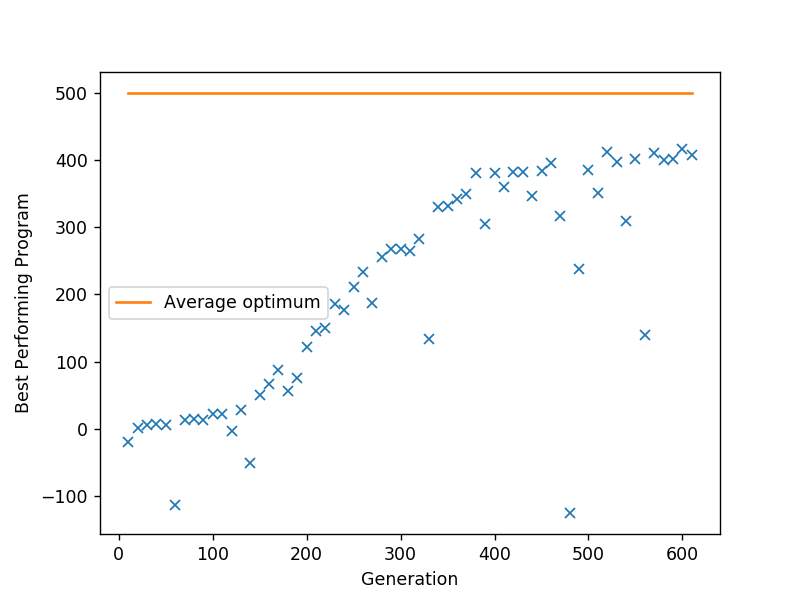

In [6]:
import matplotlib.pyplot as plt
%matplotlib notebook
x = np.arange(1,len(Gen_Selection),1)
plt.plot(x * 10, FT[1:] - 1000, 'x')
plt.plot(x * 10, [500 for y in x], label = "Average optimum")
plt.xlabel("Generation")
plt.ylabel("Best Performing Program")
plt.legend()


In [11]:
import matplotlib.pyplot as plt
%matplotlib notebook

In [12]:
x = np.linspace(0, size - 1, size)
y = np.linspace(0, size - 1, size)

In [13]:
size = 10

In [20]:
chromosome = 0.5 * np.ones(size * size)

<IPython.core.display.Javascript object>


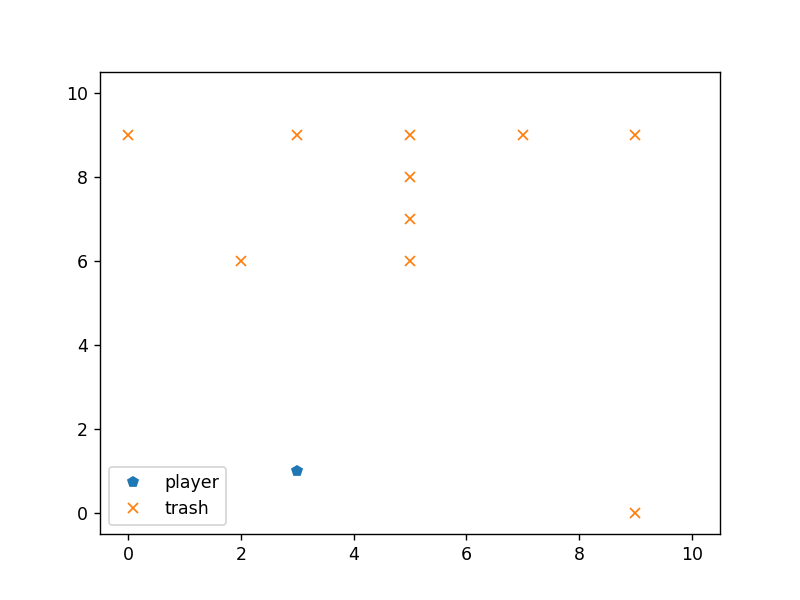

interactive(children=(IntSlider(value=0, description='c', max=199), Output()), _dom_classes=('widget-interact'…

In [25]:
Deus = Gen_Selection[len(Gen_Selection)-1]
G = Game(Deus, Predator(size, chromosome))
n_steps = np.copy(G.steps_left)
Fields = [i for i in range (n_steps+1)]
positions = [i for i in range (n_steps+1)]

score = [i for i in range (n_steps+1)]

positions[0] = np.copy(G.pos)
Fields[0] = np.copy(G.predator.field)
score[0] = np.copy(G.current_reward)


i = 1
while(G.steps_left > 0):
    G.step(G.observe_decide())
    positions[i] = np.copy(G.pos)
    score[i] = np.copy(G.current_reward)
    
    
    Fields[i] = np.copy(G.predator.field)
    i += 1
    
FieldsB = [Fields[i].astype(bool) for i in range (n_steps)]


from ipywidgets import *


fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
linep, = ax.plot([positions[0][0]], [positions[0][1]], marker = 'p', label = 'player', linestyle = '')
linef, = ax.plot(x, y, marker = 'x', label = 'trash', linestyle = '')
plt.legend()
def update(c = 0):
    
    k = np.int(c)
    print(k)
    print(c, positions[c])
    print(score[c])
    linep.set_xdata([positions[k][0]])
    linep.set_ydata([positions[k][1]])
    FD = FieldsB[c]
    datx = []
    daty = []
    
    for k in range(size):
        for j in range(size):
            if(FD[k][j] == 1):
                datx.append(k)
                daty.append(j)
                
    linef.set_xdata(datx)
    linef.set_ydata(daty)
    
    plt.ylim(top=size + 0.5)
    plt.ylim(bottom=-0.5)
    
    plt.xlim(right=size + 0.5)
    plt.xlim(left=- 0.5)
    
    fig.canvas.draw()

interact(update, c = widgets.IntSlider(min=0,max=n_steps - 1,step=1,value=0));